In [1]:
import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import os

import numpy as np
import librosa

import torch
import sys

sys.path.append('/home/jupyter/rfcx/s3prl/transformer/')
sys.path.append('/home/jupyter/rfcx/s3prl/')
sys.path.append('/home/jupyter/rfcx_submission/scripts')

from model import TransformerModel , TransformerForMaskedAcousticModel , TransformerConfig
import transformer
import load_mel
from preprocessor import Preprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
from torch import nn

In [3]:
def plot_spectrogram_to_numpy(spectrogram):
    spectrogram = spectrogram.transpose(1, 0)
    fig, ax = plt.subplots(figsize=(18, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",cmap='magma')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()

    fig.canvas.draw()


In [4]:
preprocessor= Preprocessor(hidden_size =768, dr=1, device=torch.device('cpu'))


In [5]:
audio_files= glob.glob('/home/jupyter/rfcx/data/*/*.flac')
# audio_files= glob.glob('/home/jupyter/librispeech/LibriSpeech/test-other/1688/142285/*.flac')
len(audio_files)

6719

In [6]:
input_file= audio_files[-50]
input_file

'/home/jupyter/rfcx/data/test/8aaf74b7a.flac'

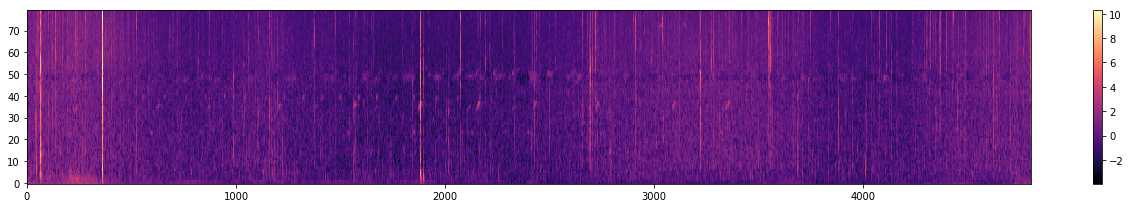

In [7]:
sample_rate=32000
y,sr= load_mel.load_audio(input_file, sample_rate)
feat= load_mel.get_spectrogram(y,sr,apply_denoise=False,return_audio=False)

load_mel.plot_feature(feat)

In [8]:

spec= torch.tensor(feat)
spec= spec.permute(1, 0)
spec_stacked, pos_enc, attn_mask = preprocessor.process_MAM_data(spec=spec)


In [9]:
spec_stacked.shape, pos_enc.shape, attn_mask.shape

(torch.Size([1, 4801, 80]), torch.Size([1, 4801, 768]), torch.Size([1, 4801]))

In [10]:
def load_transformer_model(ckpt_path,device='cpu'):


    ckpt = torch.load(ckpt_path, map_location='cpu')

    weights = ckpt['Transformer']
    config = ckpt['Settings']['Config']

    # print(ckpt.keys())


    model_config = TransformerConfig(config)
    input_dim = config['transformer']['input_dim']
    dr= model_config.downsample_rate
    hidden_size = model_config.hidden_size

    output_attention= False
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = TransformerModel(model_config,input_dim,output_attentions=output_attention).to(device)
    
    model.load_state_dict(ckpt['Transformer'])

    return model, hidden_size, dr, device



In [11]:
class Upstream_Model(torch.nn.Module):
  
    def __init__(self, transformer_model: TransformerForMaskedAcousticModel):
        super(Upstream_Model,self).__init__()
        self.transformer = transformer_model
        self.maxlen=3000
    
    def split(self,inp):
        #shape of each input is (batch_size, sequence, mel_features)
        #goal is to split the sequence if the sequence length is greater tha maxlen
        sequence_length = inp.shape[1]
        axes_length= len(inp.shape)
        
        if sequence_length> self.maxlen:
            
            sub_sequences= []
            num_subseq= sequence_length//self.maxlen
            start= 0
            
            for i in range(1,num_subseq+1):
                end= self.maxlen*i
                if axes_length==2:
                    sub_sequences.append(inp[:, start:end])
                else:
                    sub_sequences.append(inp[:, start:end, :])
                
                start=end
                
            if end<sequence_length:
                if axes_length==2:
                    sub_sequences.append(inp[:, start:])
                else:
                    sub_sequences.append(inp[:, start:, :])
        
            return sub_sequences
        else:
            return [inp]
            
        
    def forward(self, spec, pos_enc, attn_mask):
                
        split_spec= self.split(spec)
        split_pos_enc= self.split(pos_enc)
        split_attn_mask= self.split(attn_mask)
        
        layer1 ,layer2 ,layer3= [], [] ,[]
        
        for a,b,c in zip(split_spec, split_pos_enc, split_attn_mask) :
            
            _layer1, _layer2, _layer3 = self.transformer(spec_input=a,
                                        pos_enc=b,
                                        attention_mask=c,
                                        output_all_encoded_layers=True)
            
            layer1.append(_layer1)
            layer2.append(_layer2)
            layer3.append(_layer3)
            
            
        stacked_encoded_layers= torch.stack([torch.cat(layer, axis=1) for layer in [layer1, layer2, layer3]], dim=-1) # (B,N_layers, T,D)
        return stacked_encoded_layers

In [53]:
class Downstream_Model(nn.Module):
    '''
    Takes input shape of (Batch_Size, Encoded_layers, Time_step , Hidden_Size_Of_Upstream)
    for eg: (1,3,4801, 768)
    '''
    
    def __init__(self, encoder_num_layers=3, frame_length=4801, hidden_layers=768, num_classes=24):
        
        super(Downstream_Model,self).__init__()
        
        self.num_layers  = encoder_num_layers
        self.weight      = nn.Parameter(torch.ones(self.num_layers) / self.num_layers)
        self.drop1        = nn.Dropout()
        self.pool        = nn.AvgPool2d(kernel_size= (frame_length, 1))
        self.drop2       = nn.Dropout()
        self.hidden1     = nn.Linear(in_features= hidden_layers, out_features =128)
        self.act1        = nn.ReLU()
        self.drop3       = nn.Dropout()
        self.classifier  = nn.Linear(in_features= 128, out_features =num_classes)
        
    def forward(self, x):
        
        #weighted_sum. expected_output (Batch_Size, Time_step , Hidden_Size_Of_Upstream)
        softmax_weight = nn.functional.softmax(self.weight, dim=-1)
        x_weighted_sum = torch.matmul(x,softmax_weight)
        x_weighted_sum = self.drop1(x_weighted_sum)
        
        # frame-wise average pool. expected output (Batch_Size, 1 , Hidden_Size_Of_Upstream) 
        golbal_activations = self.pool(x_weighted_sum)
        golbal_activations = golbal_activations.squeeze(dim=1) #(Batch_Size, Hidden_Size_Of_Upstream) 
        golbal_activations = self.drop2(golbal_activations)
        
        hidden_layer = self.hidden1(golbal_activations)
        hidden_layer = self.act1(hidden_layer)
        hidden_layer = self.drop3(hidden_layer)
        
        classifier_layer = self.classifier(hidden_layer)
        return classifier_layer

In [54]:
# ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/pretrained_model/states-1000000.ckpt'

ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/mockingjay_mel80_no_delta_cmvn_run4/states-2000.ckpt'
# ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/mockingjay_mel80_no_delta_cmvn_run3/states-3000.ckpt'



transformer_model , hidden_size, dr, device = load_transformer_model(ckpt_path)

In [55]:
# upstream_model = Upstream_Model(transformer_model)

In [56]:
downstream_model = Downstream_Model(encoder_num_layers=3)

In [28]:
upstream_model.training , downstream_model.training

(True, True)

In [17]:
stacked_encoded_layers= upstream_model(torch.cat([spec_stacked,spec_stacked]),
                                       torch.cat([pos_enc,pos_enc]),
                                       torch.cat([attn_mask,attn_mask]))


In [57]:
x= downstream_model(stacked_encoded_layers)

In [58]:
stacked_encoded_layers.shape

torch.Size([2, 4801, 768, 3])

In [59]:
x.shape

torch.Size([2, 24])

In [ ]:
4801*768

In [21]:
x.squeeze(dim=1).shape

torch.Size([2, 768])

In [23]:
768//6

128

In [62]:
from torchsummary import summary

In [64]:
summary(downstream_model, input_size= (4801, 768, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 4801, 768]               0
         AvgPool2d-2               [-1, 1, 768]               0
           Dropout-3                  [-1, 768]               0
            Linear-4                  [-1, 128]          98,432
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 24]           3,096
Total params: 101,528
Trainable params: 101,528
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 42.20
Forward/backward pass size (MB): 28.15
Params size (MB): 0.39
Estimated Total Size (MB): 70.73
----------------------------------------------------------------


In [3]:
ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/mockingjay_mel80_no_delta_cmvn_run4/states-2000.ckpt'




In [4]:
ckpt = torch.load(ckpt_path, map_location='cpu')

In [5]:
ckpt.keys()

dict_keys(['SpecHead', 'Transformer', 'Optimizer', 'Global_step', 'Settings'])

In [6]:
config = ckpt['Settings']['Config']

In [7]:
config

{'transformer': {'input_dim': 80,
  'downsample_rate': 1,
  'hidden_size': 768,
  'num_hidden_layers': 3,
  'num_attention_heads': 12,
  'intermediate_size': 3072,
  'hidden_act': 'gelu',
  'hidden_dropout_prob': 0.1,
  'attention_probs_dropout_prob': 0.1,
  'initializer_range': 0.02,
  'layer_norm_eps': '1e-12',
  'mask_proportion': 0.15,
  'mask_consecutive_min': 7,
  'mask_consecutive_max': 7,
  'mask_allow_overlap': True,
  'mask_bucket_ratio': 1.2,
  'mask_frequency': 0,
  'noise_proportion': 0.0,
  'prune_headids': None,
  'share_layer': False,
  'max_input_length': 240000,
  'pre_layer_norm': False},
 'optimizer': {'type': 'adam',
  'learning_rate': '5e-6',
  'loss_scale': 0,
  'warmup_proportion': 0.07,
  'gradient_accumulation_steps': 8,
  'gradient_clipping': 1.0},
 'dataloader': {'n_jobs': 12,
  'batch_size': 2,
  'max_timestep': 0,
  'data_path': '/content/train/libri_mel80',
  'target_path': '',
  'phone_path': 'data/libri_phone',
  'train_set': ['train-clean-360']},
 'run

In [8]:
import yaml

In [10]:
with open('/home/jupyter/rfcx_submission/upstream_config.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False)